In [40]:
import json
from collections import Counter, defaultdict
import pickle
from utils import *
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import argparse
from torchtext.vocab import GloVe

2023-03-29 10:25:27.897230: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/lib64
2023-03-29 10:25:27.943496: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/lib64
2023-03-29 10:25:27.943523: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [3]:
class Text2SQLDataset(Dataset):
    def __init__(self, file_path, data_prefix = "train"):
        self.file_path = file_path
        self.data = pd.read_excel(os.path.join(file_path, f"{data_prefix}_data.xlsx"))
        print("Dataset Length =", len(self.data))
        with open(os.path.join(file_path, "encoder.vocab"), "r") as file:
            vocab = file.readlines()
        self.encoder_vocab = vocab
        
        with open(os.path.join(file_path, "decoder.vocab"), "r") as file:
            vocab = file.readlines()
        self.decoder_vocab = vocab
        
        with open(os.path.join(file_path, "encoder_word2idx.pickle"), "rb") as file:
            word2idx = pickle.load(file)
        with open(os.path.join(file_path, "encoder_idx2word.pickle"), "rb") as file:
            idx2word = pickle.load(file)
            
        self.en_word2idx = word2idx
        self.en_idx2word = idx2word
        
        with open(os.path.join(file_path, "decoder_word2idx.pickle"), "rb") as file:
            word2idx = pickle.load(file)
        with open(os.path.join(file_path, "decoder_idx2word.pickle"), "rb") as file:
            idx2word = pickle.load(file)
            
        self.de_word2idx = word2idx
        self.de_idx2word = idx2word
        print("Encoder Vocab Size = {}, Decoder Vocab Size = {}".format(len(self.en_word2idx), len(self.de_word2idx)))
        
    def __len__(self):        
        return len(self.data)
    
    def __getitem__(self, idx):
#         print(idx, "\n")
        try:
            query = ["<sos>"]
            question = ["<sos>"]
            query = ["<sos>"] + tokenize_query(self.data.loc[idx, "query"]) + ["<eos>"]
            question =  ["<sos>"] + tokenize_question(self.data.loc[idx, "question"]) + ["<eos>"]

            query = [self.en_word2idx[q] if q in self.en_word2idx else self.en_word2idx["<unk>"] for q in query]
            question = [self.en_word2idx[q] if q in self.en_word2idx else self.en_word2idx["<unk>"] for q in question]

            sample = {'question': question, 'query': query}
        except:
            print(idx)
            
        return sample
    
def collate(batch):
    
    max_len_ques = max([len(sample['question']) for sample in batch])
    max_len_query = max([len(sample['query']) for sample in batch])
    
    ques_lens = torch.zeros(len(batch), dtype=torch.long)
    padded_ques = torch.zeros((len(batch), max_len_ques), dtype=torch.long)
    
    query_lens = torch.zeros(len(batch), dtype=torch.long)
    padded_query = torch.zeros((len(batch), max_len_query), dtype=torch.long)
    
    for idx in range(len(batch)):
        
        query = batch[idx]['query']
        question = batch[idx]['question']
        
        ques_len = len(question)
        query_len = len(query)
        ques_lens[idx] = ques_len
        query_lens[idx] = query_len
        
        padded_ques[idx, :ques_len] = torch.LongTensor(question)
        padded_query[idx, :query_len] = torch.LongTensor(query)
        
    return {'question': padded_ques, 'query': padded_query, 'ques_lens': query_lens, 'query_lens': query_lens}

train_dataset = Text2SQLDataset("./processed_data/", "train")

Dataset Length = 7754
Encoder Vocab Size = 2040, Decoder Vocab Size = 2342


In [15]:
SPECIAL_TOKENS = ["<pad>", "<unk>", "<sos>", "<eos>", "<num_value>", "<str_value>"]
SQL_KEYWORDS = ["t"+str(i+1) for i in range(10)] + [".", ",", "(", ")", "in", "not", "and", "between", "or", "where",
            "except", "union", "intersect",
            "group", "by", "order", "limit", "having","asc", "desc",
            "count", "sum", "avg", "max", "min",
           "<", ">", "=", "!=", ">=", "<=",
            "like",
            "distinct","*",
            "join", "on", "as", "select", "from"
           ] 
SQL_KEYWORDS = dict(zip(SQL_KEYWORDS, [10]*len(SQL_KEYWORDS)))
class GloveEmbeddings():
    def __init__(self, embed_dim, word2idx):
        self.embed_dim = embed_dim
        self.word2idx = word2idx
        self.special_tokens = SPECIAL_TOKENS
        self.vocab_size = len(word2idx)
    
    def get_embedding_matrix(self):
        # Load pre-trained GloVe embeddings
        glove = GloVe(name='6B', dim=self.embed_dim)
        embedding_matrix = torch.zeros((self.vocab_size, self.embed_dim))

        embedding_matrix[0] = torch.zeros(self.embed_dim)    # Padding token
        for i in range(1,len(SPECIAL_TOKENS)):            
            embedding_matrix[i] = torch.randn(self.embed_dim)    # Start-of-sentence token
            
        for k, v in self.word2idx.items():
            if k in SPECIAL_TOKENS:
                continue
            else:            
                if k in glove.stoi:
                    embedding_matrix[v] = torch.tensor(glove.vectors[glove.stoi[k]])
                else:
                    embedding_matrix[v] = embedding_matrix[1]
#                     print("unknown token", v)

        return embedding_matrix


class LSTMEncoder(nn.Module):
    def __init__(self, input_size, embed_dim, hidden_units=1024, num_layers=1, p = 0.5, bidirectional=False, embed_matrix=None):
        super(LSTMEncoder, self).__init__()
        self.input_size = input_size
        self.embed_dim = embed_dim
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p)
        self.bidirectional = bidirectional
        self.embed_matrix = None
        if self.embed_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=0)
        else:
            self.embedding = nn.Embedding(input_size, self.embed_dim, padding_idx=0)
        self.LSTM = nn.LSTM(embed_dim, hidden_units, num_layers = num_layers, dropout=p, batch_first=True, bidirectional=bidirectional)
        
    def forward(self, x):
#         print("ENCODER INPUT SHAPE", x.shape)
        x = self.dropout(self.embedding(x))
#         print("ENCODER EMBEDDING SHAPE", x.shape)
        
        encoder_out, (ht, ct) = self.LSTM(x)        
#         print("ENCODER OUTPUT SHAPE: encoder_out, ht, ct", encoder_out.shape, ht.shape, ct.shape)
        
        return encoder_out, (ht, ct)
    
class LSTMDecoder(nn.Module):
    def __init__(self, input_size, embed_dim, hidden_units=1024, num_layers=1, p = 0.5):
        super(LSTMDecoder, self).__init__()
        self.input_size = input_size
        self.embed_dim = embed_dim
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p)
        self.embedding = nn.Embedding(input_size, self.embed_dim, padding_idx=0)
        self.LSTM = nn.LSTM(embed_dim, hidden_units, num_layers = num_layers, dropout=p, batch_first=True)
        self.fc = nn.Linear(hidden_units, input_size)
        
    def forward(self, x, h0_c0):
#         print("|== Decoder Input Shape: x, h0_c0", x.shape, len(h0_c0), h0_c0[0].shape, h0_c0[1].shape)
        x = self.dropout(self.embedding(x))
#         print("|== Decoder Embeddings Shape: x", x.shape)
        x = x.unsqueeze(1)
#         print("|== Decoder Embeddings unsqueezed(0) Shape: x", x.shape)
        decoder_out, (ht, ct) = self.LSTM(x, h0_c0)
#         print("|== Decoder Output Shape Shape: decoder_out, ht, ct", decoder_out.shape, ht.shape, ct.shape)
        
        out = self.fc(decoder_out)
#         print("|== Decoder FC OUT Shape: out", out.shape)
        
        return out, (ht, ct)
    
class Seq2Seq(nn.Module):
    def __init__(self, args):
        super(Seq2Seq, self).__init__()
        self.args = args
        self.model_type = args.model_type
        self.embed_dim = args.embed_dim        
        self.encoder_hidden_units = args.en_hidden
        self.decoder_hidden_units = args.de_hidden
        self.encoder_num_layers = args.en_num_layers
        self.decoder_num_layers = args.de_num_layers
        self.processed_data = args.processed_data
        self.encoder_word2idx = self.get_encoder_word2idx()
        self.decoder_word2idx = self.get_decoder_word2idx()
        self.encoder_input_size = len(self.encoder_word2idx)
        self.decoder_input_size = len(self.decoder_word2idx)
        self.encoder = self.get_encoder()
        self.decoder = self.get_decoder()
        
        

    def get_encoder_word2idx(self):
        with open(os.path.join(self.processed_data, "encoder_word2idx.pickle"), "rb") as file:
            word2idx = pickle.load(file)
        with open(os.path.join(self.processed_data, "encoder_idx2word.pickle"), "rb") as file:
            idx2word = pickle.load(file)
            
#         self.en_word2idx = word2idx
#         self.en_idx2word = idx2word        
        
        return word2idx
    
    def get_decoder_word2idx(self):
        
        with open(os.path.join(self.processed_data, "decoder_word2idx.pickle"), "rb") as file:
            word2idx = pickle.load(file)
        with open(os.path.join(self.processed_data, "decoder_idx2word.pickle"), "rb") as file:
            idx2word = pickle.load(file)
            
#         self.de_word2idx = word2idx
#         self.de_idx2word = idx2word
        
        return word2idx
    
    def get_encoder(self):
        print("Loading GloVe embeddings...")
        glove = GloveEmbeddings(self.embed_dim, self.encoder_word2idx)
        embedding_matrix = glove.get_embedding_matrix()
        print("Loading Encoder...")
        encoder = LSTMEncoder(input_size = self.encoder_input_size, embed_dim = self.embed_dim, 
                              hidden_units=self.encoder_hidden_units, num_layers=self.encoder_num_layers, p = 0.3, bidirectional=False, embed_matrix=embedding_matrix)
        
        return encoder
    
    def get_decoder(self):
        
        if self.model_type == "Seq2Seq":
            print("Loading Seq2Seq LSTM Decoder...")
            decoder = LSTMDecoder(input_size = self.decoder_input_size, embed_dim = self.embed_dim, 
                              hidden_units=self.decoder_hidden_units, num_layers=self.decoder_num_layers, p = 0.3)
        
        elif self.model_type == "Seq2SeqAttn":
            pass
        else:
            pass
        return decoder
        
    def forward(self, question, query, tf_ratio=0.5):
        batch_size = question.shape[0]
        target_len = query.shape[1]
        
        _, (hidden, cell) = self.encoder(question)
        
        target_vocab_size = self.decoder_input_size
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)
        
        x = query[:,0]
        for t in range(1, target_len):
            output, (hidden, cell) = self.decoder(x, (hidden, cell))
#             print("Seq2seq out shape", output.shape)
            output = output.squeeze(1)
            outputs[:,t,:] = output
            x = output.argmax(dim=1)
        
        return outputs
        
        
        

    
    


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = Seq2Seq(args).to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
schedulers = [
        optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1, last_epoch=- 1, verbose=False),
        optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs, verbose=False)
        ]
scheduler =  schedulers[1]

train_loader = DataLoader(train_dataset, batch_size = args.batch_size, shuffle=True, 
                          num_workers=args.num_workers, collate_fn=collate)
for epoch in range(args.epochs):
    print("Epoch:", epoch)
    for i, data in enumerate(train_loader):
    #     print(data['question'].shape, data['query'].shape, data['ques_lens'].shape, data['query_lens'].shape)
        optimizer.zero_grad()
        question = data['question'].to(device)
        query = data['query'].to(device)
        output = model(question, query)
    #     print("output and target", output.shape, query.shape)
        output = output.reshape(-1, output.shape[2])
        query = query.reshape(-1)    
    #     print("reshaped output and target", output.shape, query.shape)
        loss = criterion(output, query)
        loss.backward()
        
        optimizer.step()
        if i % 100 == 0:
            print(loss.item())
    scheduler.step()
#     break
    

In [133]:
!nvidia-smi

Mon Mar 20 10:11:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:C1:00.0 Off |                  Off |
| 33%   29C    P8    16W / 230W |   1375MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
class ARGS():
    def __init__(self):
        self.model_type = "Seq2Seq"
        self.data_dir = "./data"
        self.batch_size = 16
        self.num_workers = 8
        self.epochs = 100
        self.en_hidden = 512
        self.de_hidden = 512
        self.en_num_layers = 1
        self.de_num_layers = 1
        self.embed_dim = 300
        self.processed_data = "./processed_data/"
        
args = ARGS()

def get_parser():
    """
    Generate a parameter parser
    """
    # parse parameters
    parser = argparse.ArgumentParser(description="Text2SQL")
    
    # model type
    parser.add_argument("--model_type", type=str, default="Seq2Seq", help="Select the model you want to run from [Seq2Seq, Seq2SeqAttn].")

    # path to data files.
    parser.add_argument("--data_dir", type=str, default="./data", help="Path to dataset directory.")

    # path to result files.
    parser.add_argument("--result_dir", type=str, default="./results", help="Path to dataset directory.")

    # path to model checkpoints.
    parser.add_argument("--checkpoint_dir", type=str, default="./checkpoints", help="Path to model checkpoints.")
    
    # path to model checkpoints.
    parser.add_argument("--processed_data", type=str, default="./processed_data", help="Path to processed data.")

    # batch size training
    parser.add_argument("--batch_size", type=int, default=16, help="Batch size to be used during training.")

    # number of workers for dataloader
    parser.add_argument("--num_workers", type=int, default=8, help="Number of workers used for dataloading.")

    # max number of epochs
    parser.add_argument("--epochs", type=int, default=100, help="Number of workers used for dataloading.")

    parser.add_argument("--en_hidden", type=int, default=512, help="Encoder Hidden Units")
    
    parser.add_argument("--de_hidden", type=int, default=512, help="Decoder Hidden Units")

    parser.add_argument("--en_num_layers", type=int, default=1, help="Number of lstm layers in encoder.")
    
    parser.add_argument("--de_num_layers", type=int, default=1, help="Number of lstm layers in decoder.")    
    
    parser.add_argument("--embed_dim", type=int, default=300, help="Embeddings dimension for both encoder and decoder.")

    return parser
# parser = get_parser()
# args = parser.parse_args()
# args.data_dir = os.path.relpath(args.data_dir)
# print(args)


In [3]:
import pandas as pd
import numpy as np
df = pd.read_excel("./processed_data/val_data.xlsx")
df.head()

,db_id,question,query,orig_query
0,music_1,what is the most popular file format ?,select formats from files group by formats ord...,select formats from files group by formats ord...
1,scholar,who is the most published author in syntactic ...,"select distinct count ( t4 . paperid ) , t3 . ...","select distinct count ( t4.paperid ) , t3.au..."
2,flight_4,find the name of airline which runs the most n...,select t1 . name from airlines as t1 join rout...,select t1.name from airlines as t1 join routes...
3,cre_Docs_and_Epenses,how many documents have expenses ?,select count ( * ) from documents_with_expenses,select count(*) from documents_with_expenses
4,machine_repair,list the names of technicians in ascending ord...,select name from technician order by age asc,select name from technician order by age asc


In [5]:
df.loc[np.array([3,1,4]), 'db_id']

3    cre_Docs_and_Epenses
1                 scholar
4          machine_repair
Name: db_id, dtype: object

In [6]:
np.sort(np.array([3,1,4]))

array([1, 3, 4])

In [16]:
with open("./results/seq2seq/train_eval_results.txt", "r") as file:
    data = file.readlines()
    
data[0].split()[-1], data[1].split()[-1], data[3].split()[-1], data[6].split()[-1]

('all', '1939', '0.000', '0.000')

In [20]:
import torch
a = torch.randn(1, 5)
a

tensor([[ 1.8804, -0.6410, -1.2031,  1.0786,  0.7089]])

In [23]:
v, i = a.topk(3, dim=1)
v, i

(tensor([[1.8804, 1.0786, 0.7089]]), tensor([[0, 3, 4]]))

In [24]:
for j, ind in enumerate(i):
    print(j, ind)
    

0 tensor([0, 3, 4])


In [10]:
from transformers import BertTokenizer, BertModel

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [5]:
sentences = ["what is your name and what the fuck are you doing?", "What the hell is this"]

In [6]:
encoding = tokenizer(sentences,return_tensors='pt', padding=True, truncation=True)

In [7]:
encoding["input_ids"]

tensor([[ 101, 1184, 1110, 1240, 1271, 1105, 1184, 1103, 9367, 1132, 1128, 1833,
          136,  102],
        [ 101, 1327, 1103, 2630, 1110, 1142,  102,    0,    0,    0,    0,    0,
            0,    0]])

In [8]:
encoding["attention_mask"]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])

In [39]:
type(encoding)

transformers.tokenization_utils_base.BatchEncoding

In [38]:
tokenizer.encode(sentences[0])
tokenizer.att

[101,
 1184,
 1110,
 1240,
 1271,
 1105,
 1184,
 1103,
 9367,
 1132,
 1128,
 1833,
 136,
 102]

In [11]:
model = BertModel.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
out = model(**encoding)

In [19]:
out["last_hidden_state"].shape

torch.Size([2, 14, 768])

In [21]:
out["last_hidden_state"]

tensor([[[ 0.3729,  0.1147,  0.1001,  ..., -0.0861,  0.3471, -0.3148],
         [ 0.7357, -0.6554,  0.7085,  ..., -0.5736, -0.0645, -0.2666],
         [ 0.5696,  0.1358, -0.0218,  ..., -0.2349,  0.0239, -0.1064],
         ...,
         [ 0.1431, -0.2598,  0.1951,  ...,  0.1730, -0.0361, -0.3128],
         [ 0.4469, -0.4143, -0.0081,  ...,  0.1368,  0.0194,  0.0584],
         [ 1.0860, -0.8176, -0.6764,  ...,  0.2978,  0.7109, -0.5961]],

        [[ 0.4141,  0.5203,  0.0739,  ..., -0.0476,  0.3850, -0.2247],
         [ 0.5971, -0.3388,  0.5496,  ..., -0.1808, -0.0893,  0.0762],
         [-0.3980, -0.1015,  0.4205,  ...,  0.8113, -0.1913,  0.2015],
         ...,
         [-0.2750, -0.2226,  0.5174,  ..., -0.3173,  0.5100,  0.2175],
         [-0.3253, -0.2268,  0.5394,  ..., -0.2931,  0.5409,  0.2074],
         [-0.2908, -0.3561,  0.6060,  ..., -0.3801,  0.5311,  0.2349]]],
       grad_fn=<NativeLayerNormBackward>)

In [23]:
out["last_hidden_state"]

tensor([[[ 0.3729,  0.1147,  0.1001,  ..., -0.0861,  0.3471, -0.3148],
         [ 0.7357, -0.6554,  0.7085,  ..., -0.5736, -0.0645, -0.2666],
         [ 0.5696,  0.1358, -0.0218,  ..., -0.2349,  0.0239, -0.1064],
         ...,
         [ 0.1431, -0.2598,  0.1951,  ...,  0.1730, -0.0361, -0.3128],
         [ 0.4469, -0.4143, -0.0081,  ...,  0.1368,  0.0194,  0.0584],
         [ 1.0860, -0.8176, -0.6764,  ...,  0.2978,  0.7109, -0.5961]],

        [[ 0.1984,  0.4940,  0.2771,  ..., -0.2891,  0.4426, -0.5308],
         [ 0.2706, -0.0757,  0.3381,  ...,  0.2551, -0.3673, -0.0515],
         [-0.3087,  0.0093,  0.6192,  ...,  0.4455, -0.1667,  0.0915],
         ...,
         [ 0.2430,  0.3112, -0.0756,  ...,  0.2716,  0.2578, -0.2025],
         [ 0.2119,  0.4927, -0.2051,  ...,  0.1447,  0.2936, -0.3364],
         [ 0.3320,  0.2555, -0.1233,  ...,  0.2283,  0.0179, -0.1682]]],
       grad_fn=<NativeLayerNormBackward>)

In [32]:
bert_model = BertModel.from_pretrained('bert-base-cased')


print("BERT Encoder with frozen embeddings.")
for name, param in bert_model.named_parameters():
    param.requires_grad = False

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT Encoder with frozen embeddings.


In [36]:
for i in range(4):
    for param in bert_model.encoder.layer[i].parameters():
        param.requires_grad = True

In [37]:
sum(p.numel() for p in bert_model.parameters()), sum(p.numel() for p in bert_model.parameters() if p.requires_grad)

(108310272, 28351488)

In [30]:
bert_model.bert.parameters()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [41]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import json

In [48]:
import json
with open("./results/to_generate_plots/loss_trackerlstm_lstm.json", "r+") as file:
    loss1 = json.load(file)

with open("./results/to_generate_plots/loss_trackerlstm_lstm_attn.json", "r+") as file:
    loss2 = json.load(file)
    
with open("./results/to_generate_plots/loss_trackerbert_lstm_attn_frozen.json", "r+") as file:
    loss3 = json.load(file)

with open("./results/to_generate_plots/loss_trackerbert_lstm_attn_tuned.json", "r+") as file:
    loss4 = json.load(file)


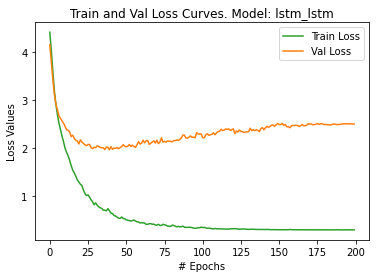

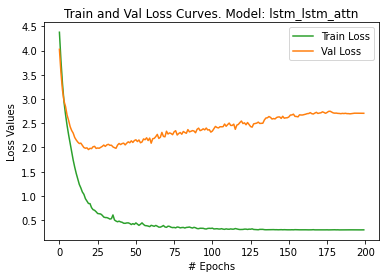

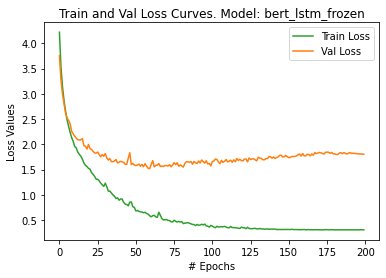

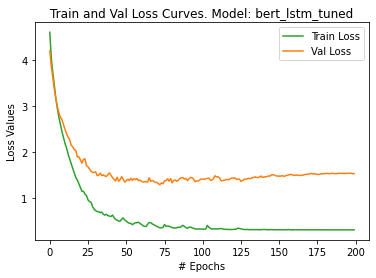

In [54]:
fig = plt.figure(2)
plt.plot(list(range(len(loss1['train']))), loss1['train'], c="tab:green", label="Train Loss")
plt.plot(list(range(len(loss1['val']))), loss1['val'], c="tab:orange", label="Val Loss")
plt.title(f"Train and Val Loss Curves. Model: lstm_lstm")
plt.xlabel("# Epochs")
plt.ylabel("Loss Values")
plt.legend()
fig.savefig(os.path.join("./results/plots", "loss_lstm_lstm.png"), dpi= 300, pad_inches=0.1, format="png")
fig.savefig(os.path.join("./results/plots", "loss_lstm_lstm.pdf"), dpi= 300, pad_inches=0.1)

fig = plt.figure(3)
plt.plot(list(range(len(loss2['train']))), loss2['train'], c="tab:green", label="Train Loss")
plt.plot(list(range(len(loss2['val']))), loss2['val'], c="tab:orange", label="Val Loss")
plt.title(f"Train and Val Loss Curves. Model: lstm_lstm_attn")
plt.xlabel("# Epochs")
plt.ylabel("Loss Values")
plt.legend()
fig.savefig(os.path.join("./results/plots", "loss_lstm_lstm_attn.png"), dpi= 300, pad_inches=0.1, format="png")
fig.savefig(os.path.join("./results/plots", "loss_lstm_lstm_attn.pdf"), dpi= 300, pad_inches=0.1)

fig = plt.figure(4)
plt.plot(list(range(len(loss3['train']))), loss3['train'], c="tab:green", label="Train Loss")
plt.plot(list(range(len(loss3['val']))), loss3['val'], c="tab:orange", label="Val Loss")
plt.title(f"Train and Val Loss Curves. Model: bert_lstm_frozen")
plt.xlabel("# Epochs")
plt.ylabel("Loss Values")
plt.legend()
fig.savefig(os.path.join("./results/plots", "loss_bert_lstm_frozen.png"), dpi= 300, pad_inches=0.1, format="png")
fig.savefig(os.path.join("./results/plots", "loss_bert_lstm_frozen.pdf"), dpi= 300, pad_inches=0.1)

fig = plt.figure(5)
plt.plot(list(range(len(loss4['train']))), loss4['train'], c="tab:green", label="Train Loss")
plt.plot(list(range(len(loss4['val']))), loss4['val'], c="tab:orange", label="Val Loss")
plt.title(f"Train and Val Loss Curves. Model: bert_lstm_tuned")
plt.xlabel("# Epochs")
plt.ylabel("Loss Values")
plt.legend()
fig.savefig(os.path.join("./results/plots", "loss_bert_lstm_tuned.png"), dpi= 300, pad_inches=0.1, format="png")
fig.savefig(os.path.join("./results/plots", "loss_bert_lstm_tuned.pdf"), dpi= 300, pad_inches=0.1)


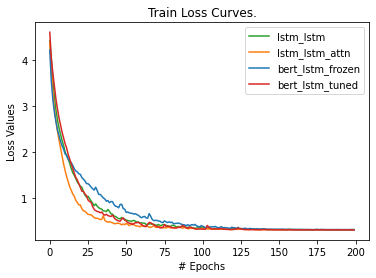

In [53]:
fig = plt.figure(2)
plt.plot(list(range(len(loss1['train']))), loss1['train'], c="tab:green", label="lstm_lstm")
plt.plot(list(range(len(loss2['train']))), loss2['train'], c="tab:orange", label="lstm_lstm_attn")
plt.plot(list(range(len(loss3['train']))), loss3['train'], c="tab:blue", label="bert_lstm_frozen")
plt.plot(list(range(len(loss4['train']))), loss4['train'], c="tab:red", label="bert_lstm_tuned")
plt.title(f"Train Loss Curves.")
plt.xlabel("# Epochs")
plt.ylabel("Loss Values")
plt.legend()
fig.savefig(os.path.join("./results/plots", "train_loss_all.png"), dpi= 300, pad_inches=0.1, format="png")
fig.savefig(os.path.join("./results/plots", "train_loss_all.pdf"), dpi= 300, pad_inches=0.1)

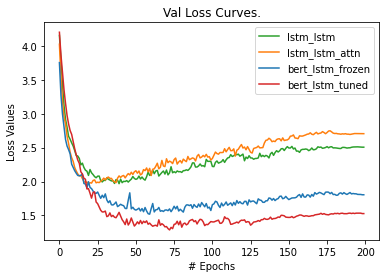

In [52]:
fig = plt.figure(2)
plt.plot(list(range(len(loss1['val']))), loss1['val'], c="tab:green", label="lstm_lstm")
plt.plot(list(range(len(loss2['val']))), loss2['val'], c="tab:orange", label="lstm_lstm_attn")
plt.plot(list(range(len(loss3['val']))), loss3['val'], c="tab:blue", label="bert_lstm_frozen")
plt.plot(list(range(len(loss4['val']))), loss4['val'], c="tab:red", label="bert_lstm_tuned")
plt.title(f"Val Loss Curves.")
plt.xlabel("# Epochs")
plt.ylabel("Loss Values")
plt.legend()
fig.savefig(os.path.join("./results/plots", "val_loss_all.png"), dpi= 300, pad_inches=0.1, format="png")
fig.savefig(os.path.join("./results/plots", "val_loss_all.pdf"), dpi= 300, pad_inches=0.1)

In [65]:
import csv
with open("./lstm_lstm_attn_test_pred.txt", "r") as f:
        pred_file_content = f.readlines()
df = pd.DataFrame([line.replace(" \n", "") for line in pred_file_content])
df.to_csv("test.csv", index=False, header=False, quoting=csv.QUOTE_NONE,escapechar='\\')

In [68]:
pd.read_csv("test.csv", escapechar='\\', header=None)

,0
0,select ppos from files group by formats order ...
1,"select distinct count ( t4 . paperid ) , t3 . ..."
2,select t1 . name from airlines as t1 join rout...
3,select count ( * ) from documents_with_expenses
4,select name from technician order by age asc
...,...
1934,"select grade from highschooler where name = ""K..."
1935,select <unk> from assessment_notes
1936,select count ( * ) from country
1937,select count ( * ) from company
